# Introduction

This notebook illustrates how DCTR works on a simple 1D Gaussian example with __different sized training and reweighting validation datasets (liklihood ratios).__

It will cover how to:

- train a classifier between two samples drawn from a Gaussian distribution, $\mathcal{N}(\mu, 1)$, with different mean $\mu$

- parametrize the classifier to reweight from $\mathcal{N}(0, 1)$ to $\mathcal{N}(\mu, 1)$ for any $\mu$. 

- use a parametried classifier to infer what $\mu$ a sample was created with. 

## Imports

In [1]:
# standard library imports
from __future__ import absolute_import, division, print_function

import tensorflow as tf
from tensorflow.keras.layers import Lambda, Dense, Input, Layer, Dropout
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback
from tensorflow.keras.initializers import Constant
from tensorflow.keras.backend import concatenate

# standard numerical library imports
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt

In [2]:
# Global plot settings
from matplotlib import rc
import matplotlib.font_manager
rc('font', family='serif')
rc('text', usetex=True)
rc('font', size=22) 
rc('xtick', labelsize=15) 
rc('ytick', labelsize=15) 
rc('legend', fontsize=15)

The reweighted $\mu=0$ dataset matches the $\mu=1$!

# Reweighting $\mathcal{N}(0, 1)$ to $\mathcal{N}(\mu, 1)$ with one model for any $\mu$

We will now parametrize our network by giving it a $\mu$ value in addition to $X_i\sim\mathcal{N}(\mu, 1)$.

First we uniformly sample $\mu$ values in some range

In [3]:
n_data_points = 10**6
mu_min = -2
mu_max = 2
mu_values1 = np.random.uniform(mu_min, mu_max, n_data_points) 
mu_values2 = np.random.uniform(mu_min, mu_max, 4*n_data_points) # Note 4*

We then sample from normal distributions with this $\mu$ value

In [4]:
X0 = [(np.random.normal(0, 1), mu) for mu in mu_values1] # Note the zero in normal(0, 1) 
X1 = [(np.random.normal(mu, 1), mu) for mu in mu_values2] #X1 will be x4 the size of X0

Please note that the samples in X0 are not paired with $\mu=0$ as this would make the task trivial. 

Instead it is paired with the $\mu$ values uniformly sampled in the specified range [mu_min, mu_max].

For every value of $\mu$ in mu_values, the network sees one event drawn from $\mathcal{N}(0,1)$ and $\mathcal{N}(\mu,1)$, and it learns to classify them. 

I.e. we have one network that's parametrized by $\mu$ that classifies between events from $\mathcal{N}(0,1)$ and $\mathcal{N}(\mu,1)$, and a trained network will give us the likelihood ratio to reweight from one to another. 

In [5]:
Y0 = to_categorical(np.zeros(n_data_points), num_classes=2)
Y1 = to_categorical(np.ones(4*n_data_points), num_classes=2)

X = np.concatenate((X0, X1))
Y = np.concatenate((Y0, Y1))

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
print(np.shape(X_train))
print(np.shape(X_test))
print(np.shape(Y_train))
print(np.shape(Y_test))

(4000000, 2)
(1000000, 2)
(4000000, 2)
(1000000, 2)


## Build Model

In [6]:
inputs = Input((2,))
hidden_layer_1 = Dense(50, activation='relu')(inputs)
hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)

outputs = Dense(2, activation='softmax')(hidden_layer_3)

dctr_model = Model(inputs = inputs, outputs = outputs)
dctr_model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics =['accuracy'])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


## Train DCTR model

In [7]:
earlystopping = EarlyStopping(patience = 10,
                              restore_best_weights=True)
dctr_model.fit(X_train, Y_train, 
          epochs=200, 
          batch_size = 10000,
          validation_data = (X_test, Y_test),
          callbacks = [earlystopping])

Train on 4000000 samples, validate on 1000000 samples
Epoch 1/200
4000000/4000000 [==============================] - 6s 2us/sample - loss: 0.4261 - acc: 0.8207 - val_loss: 0.4128 - val_acc: 0.8255
Epoch 2/200
4000000/4000000 [==============================] - 6s 2us/sample - loss: 0.4130 - acc: 0.8256 - val_loss: 0.4123 - val_acc: 0.8258
Epoch 3/200
4000000/4000000 [==============================] - 6s 2us/sample - loss: 0.4128 - acc: 0.8256 - val_loss: 0.4121 - val_acc: 0.8260
Epoch 4/200
4000000/4000000 [==============================] - 6s 2us/sample - loss: 0.4127 - acc: 0.8256 - val_loss: 0.4120 - val_acc: 0.8260
Epoch 5/200
4000000/4000000 [==============================] - 6s 2us/sample - loss: 0.4127 - acc: 0.8255 - val_loss: 0.4122 - val_acc: 0.8259
Epoch 6/200
4000000/4000000 [==============================] - 6s 1us/sample - loss: 0.4127 - acc: 0.8256 - val_loss: 0.4121 - val_acc: 0.8258
Epoch 7/200
4000000/4000000 [==============================] - 6s 2us/sample - loss: 0.4

## Validate DCTR for any $\mu$

In [8]:
mu1 = -1.5
assert mu1>=mu_min and mu1<=mu_max # choose mu1 in valid range

X0_val = np.random.normal(0, 1, 3*n_data_points) # X0_val will be 3x the size of X1_val
X1_val = np.random.normal(mu1, 1, n_data_points)

In [9]:
X_input = np.array([(x, mu1) for x in X0_val])

In [10]:
preds = dctr_model.predict(X_input)

liklihood_raio_train = len(X0) / len(X1)
liklihood_raio_val = len(X1_val) / len(X0_val)
liklihood_ratio = liklihood_raio_train * liklihood_raio_val
print(liklihood_ratio)

weights = liklihood_ratio * (preds[:, 1] / preds[:, 0])

0.08333333333333333


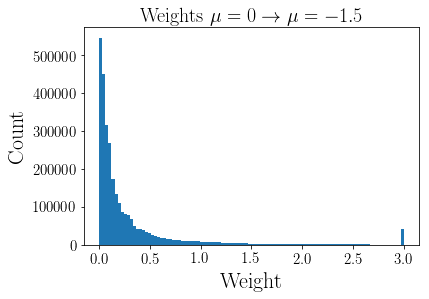

In [13]:
clip_val = 3
bins = np.linspace(0, clip_val, 101)
plt.hist(np.clip(weights, 0, clip_val), bins = bins)
plt.xlabel("Weight")
plt.ylabel('Count')
plt.title(r"Weights $\mu = 0 \rightarrow \mu = -1.5$", fontsize = 20)
plt.show()

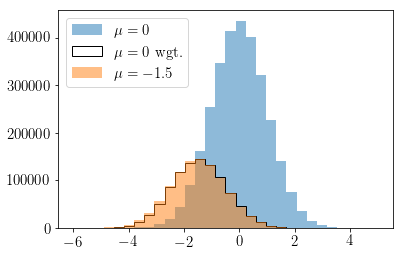

In [12]:
bins = np.linspace(-6,5,31)
plt.hist(X0_val, bins = bins, alpha = 0.5, label = r'$\mu=0$')
plt.hist(X0_val, bins = bins, label = r'$\mu=0$ wgt.', weights=weights, histtype='step', color='k')
plt.hist(X1_val, bins = bins, alpha = 0.5, label = r'$\mu={}$'.format(mu1))
plt.legend()
plt.show()